# Simulate primary drying with known Kv and Rp


Since this documentation example is a Jupyter notebook, inside the LyoPRONTO file structure, it needs to be directed to the LyoPRONTO code, which means adding `../../` to `sys.path`.
However, this step will in general not be necessary.

In [1]:
import sys
sys.path.append('../../')

We need a few imports:

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc as matplotlibrc
from ruamel.yaml import YAML
yaml = YAML()

import lyopronto as lp

Then, we provide all the necessary simulation parameters.

In [3]:

# Set up the simulation settings
# This needs to be a dict with string keys, which can be expressed in YAML as well
sim = yaml.load("""
tool: Primary Drying Calculator
Kv_known: Y
Rp_known: Y
Variable_Pch: N
Variable_Tsh: N
""")
# Or, equivalently:
sim = {
    'tool':'Primary Drying Calculator',
    'Kv_known':'Y',
    'Rp_known':'Y',
    'Variable_Pch':'N',
    'Variable_Tsh':'N'}


# Vial and fill properties
vial = {
    # Av = Vial area in cm^2
    'Av': 3.80,
    # Ap = Product Area in cm^2
    'Ap': 3.14,
    # Vfill = Fill volume in mL
    'Vfill': 2.0
}

In [4]:

# Product properties
product = {
    # cSolid = Fractional concentration of solute in the frozen solution
    'cSolid': 0.05,
    # Product Resistance Parameters
    'R0': 1.4, # cm^2-hr-Torr/g
    'A1': 16.0, # cm-hr-Torr/g
    'A2': 0.0, # 1/cm
    # Critical product temperature
    # At least 2 to 3 deg C below collapse or glass transition temperature
    'T_pr_crit': - 5 # in deg C
}


In [5]:
# Vial Heat Transfer Parameters
ht = {
    'KC': 2.75e-4, # cal/s-cm^2-K
    'KP': 8.93e-4, # cal/s-cm^2-K-Torr
    'KD': 0.46     # 1/Torr
}

# Chamber Pressure
Pchamber = {
    # setpt = Chamber pressure set points in Torr
    'setpt': [0.15],
    # dt_setpt = Time for which chamber pressure set points are held in min
    'dt_setpt': [1800.0],
    # ramp_rate = Chamber pressure ramping rate in Torr/min
    'ramp_rate': 0.5
}

Tshelf = {
    # init = Intial shelf temperature in C
    'init': -35.0,
    # setpt = Shelf temperature set points in C
    'setpt': [20.0],
    # dt_setpt = Time for which shelf temperature set points are held in min
    'dt_setpt': [1800.0],
    # ramp_rate = Shelf temperature ramping rate in C/min
    'ramp_rate': 1.0
}

# Time step
dt = 0.01    # hr


Now, we are ready to actually run the simulation, which is `lyopronto.calc_knownRp.dry`.

In [6]:

output_table = lp.calc_knownRp.dry(vial,product,ht,Pchamber,Tshelf,dt)


It's a good idea, particularly when you are exploring interactively, to write the simulation input and output to disk together so that as you do later analysis, you have a record of what you did. Uncommenting the following code will do so.

Previously the inputs were recorded as a two-column CSV, which records info but isn't very readable (and frankly not very useful to a machine either). YAML provides a somewhat more sensible format, and fortunately a Python dictionary can be readily represented in YAML.

In [7]:
sim_setup = {
    'sim': sim,
    'vial': vial,
    'product': product,
    'ht': ht,
    'Pchamber': Pchamber,
    'Tshelf': Tshelf,
    'dt': dt,
}

# # Write input data to disk as YAML
# import time
# current_time = time.strftime("%Y%m%d_%H%M%S")
# try:
#     yamlfile = open('lyopronto_input_'+current_time+'.yaml', 'w')
#     yaml.dump(sim_setup, yamlfile)
# finally:
#     yamlfile.close()

# # Write simulation data to disk as CSV
# try:
#     csvfile = open('lyopronto_output_'+current_time+'.csv', 'w')
#     writer = csv.writer(csvfile)
#     writer.writerow(['Time [hr]','Sublimation Temperature [C]','Vial Bottom Temperature [C]', 'Shelf Temperature [C]','Chamber Pressure [mTorr]','Sublimation Flux [kg/hr/m^2]','Percent Dried'])
#     for i in range(0,len(output_table)):
#         writer.writerow(output_table[i])
# finally:
#     csvfile.close()

Finally, it's a good idea to plot everything. Here, again, you could save plots to disk by uncommenting the lines below.

In [8]:

matplotlibrc('text.latex', preamble=r'\usepackage{color}')
matplotlibrc('text',usetex=False)
plt.rcParams['font.family'] = 'Arial'

figwidth = 30
figheight = 20
lineWidth = 5
markerSize = 20


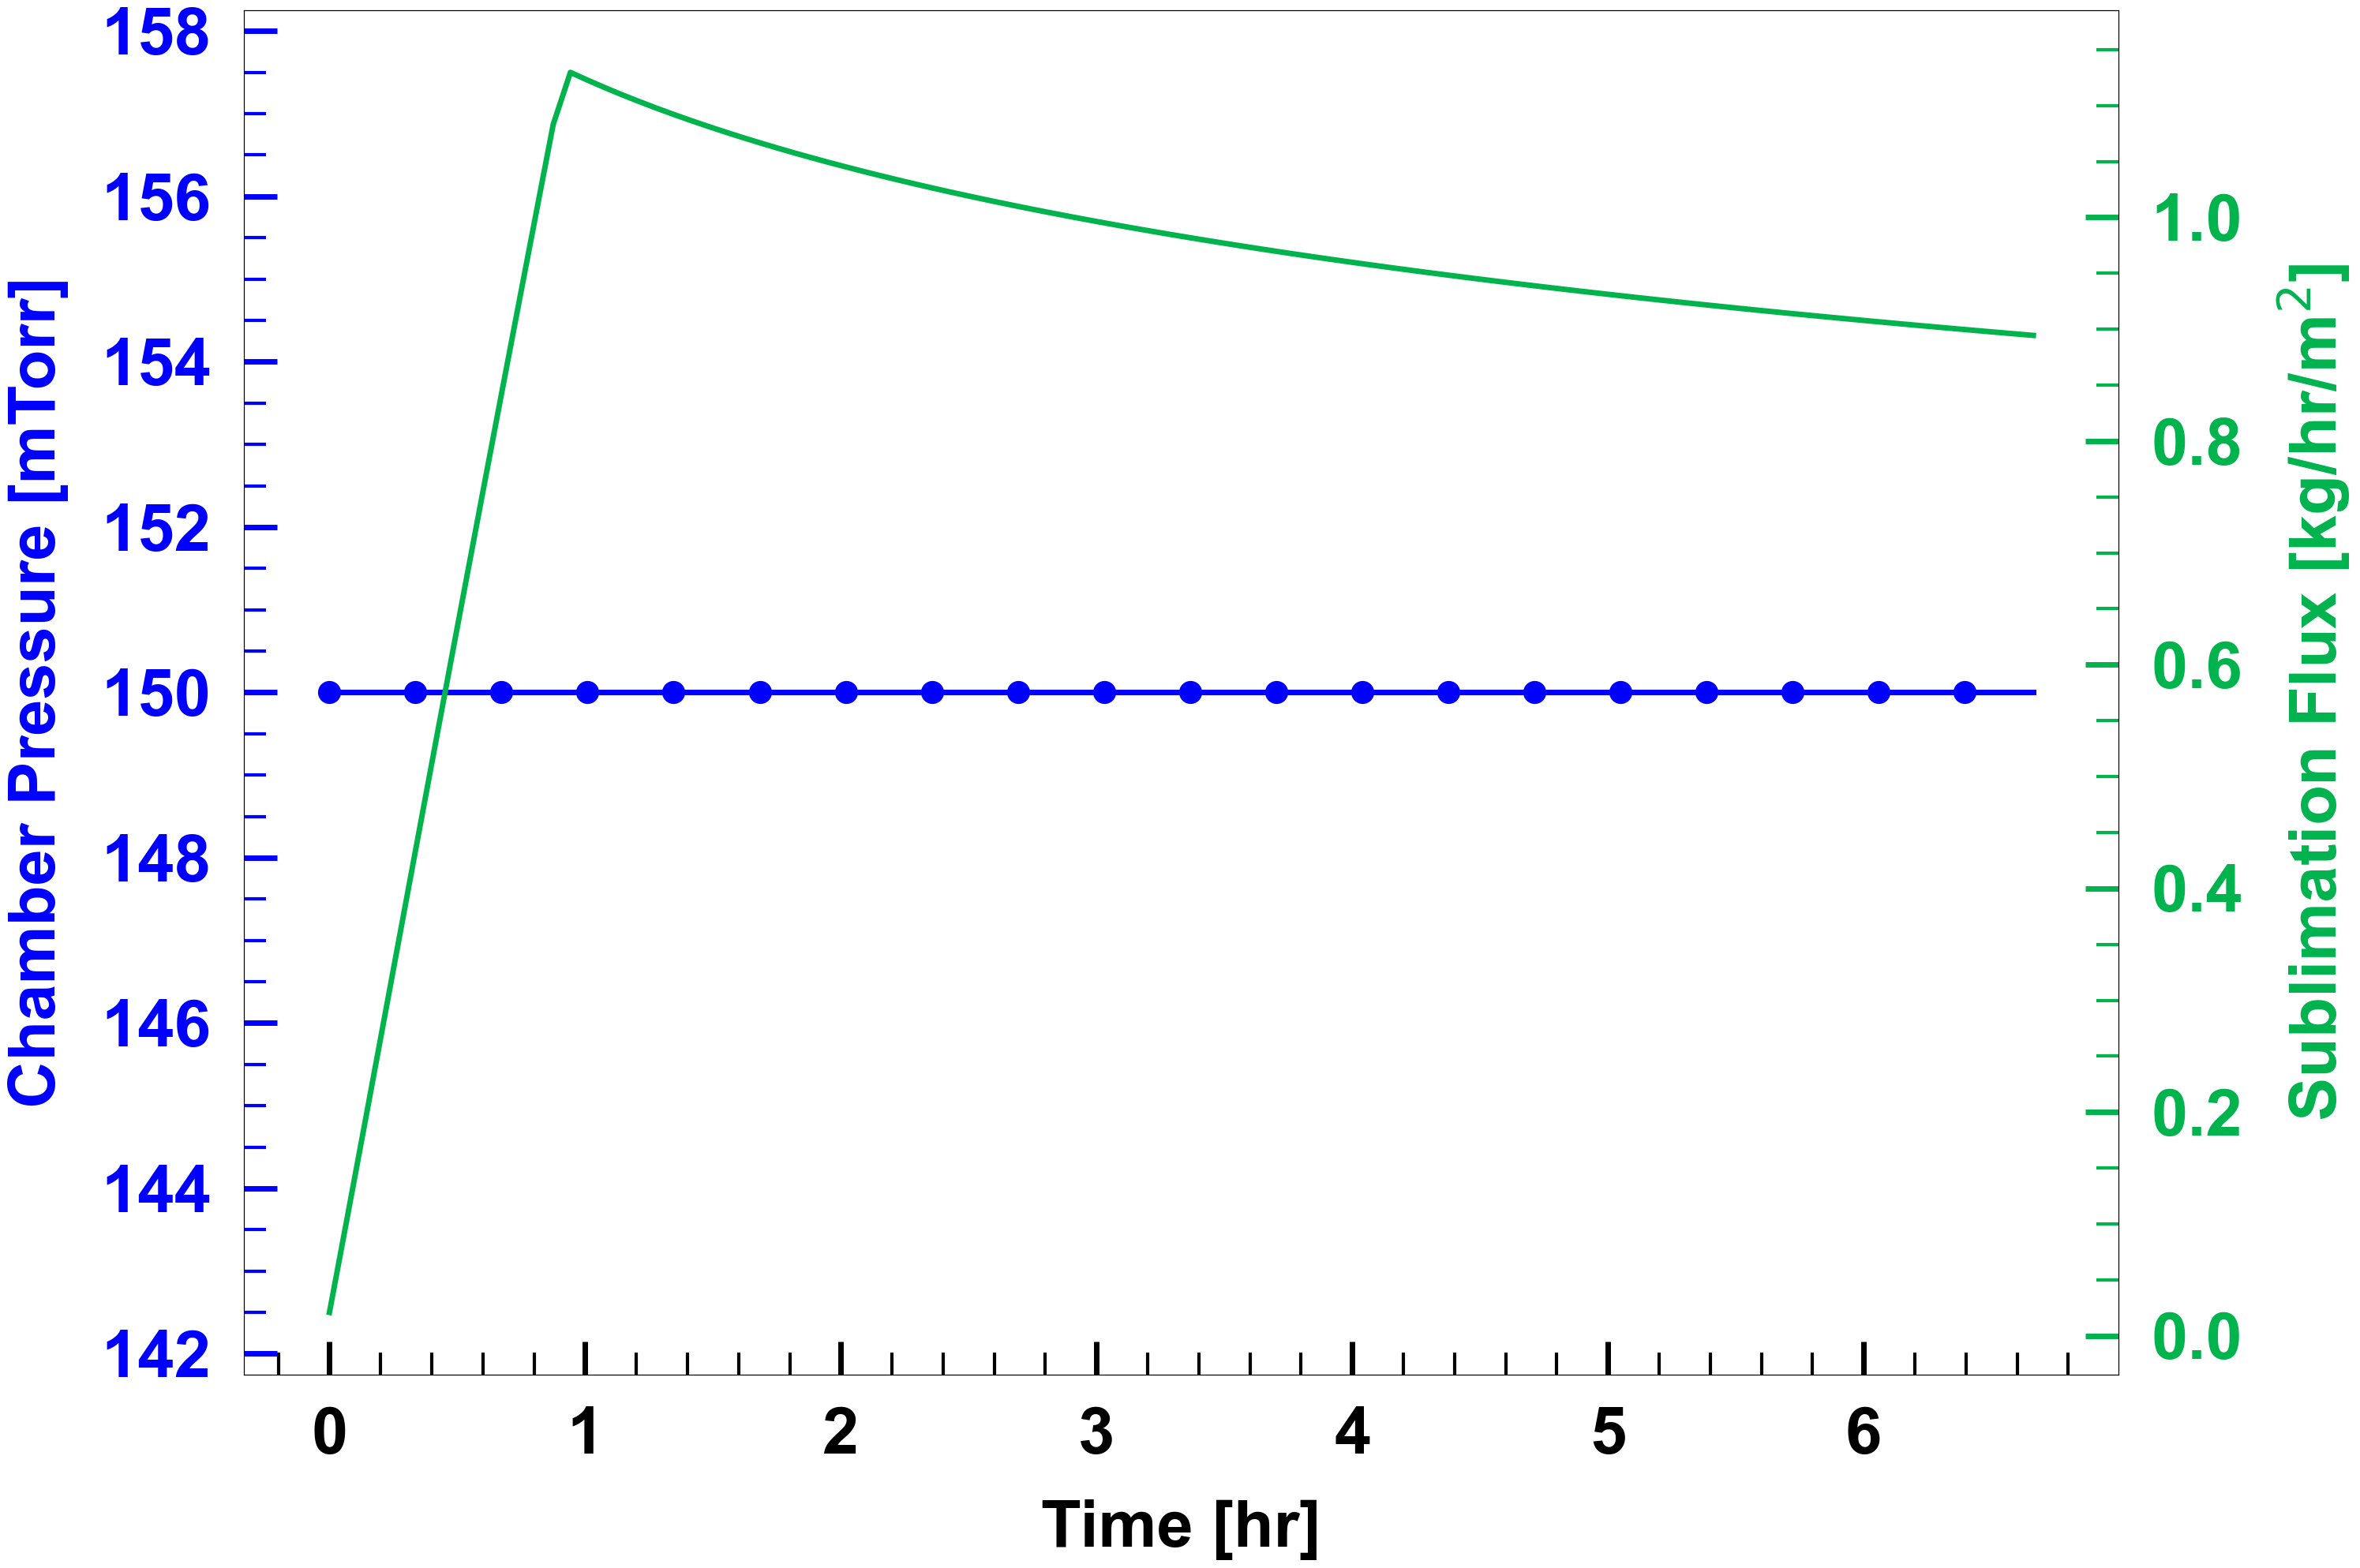

In [9]:

fig = plt.figure(0,figsize=(figwidth,figheight))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()
ax1.plot(output_table[:,0],output_table[:,4],'-o',color='b',markevery=5,linewidth=lineWidth, markersize=markerSize, label = "Chamber Pressure")
ax2.plot(output_table[:,0],output_table[:,5],'-',color=[0,0.7,0.3],linewidth=lineWidth, label = "Sublimation Flux")

lp.plot_styling.axis_style_pressure(ax1)
lp.plot_styling.axis_style_subflux(ax2)

plt.tight_layout()
# figure_name = 'lyopronto_pressure_subflux_'+current_time+'.pdf'
# plt.savefig(figure_name)
# plt.close()


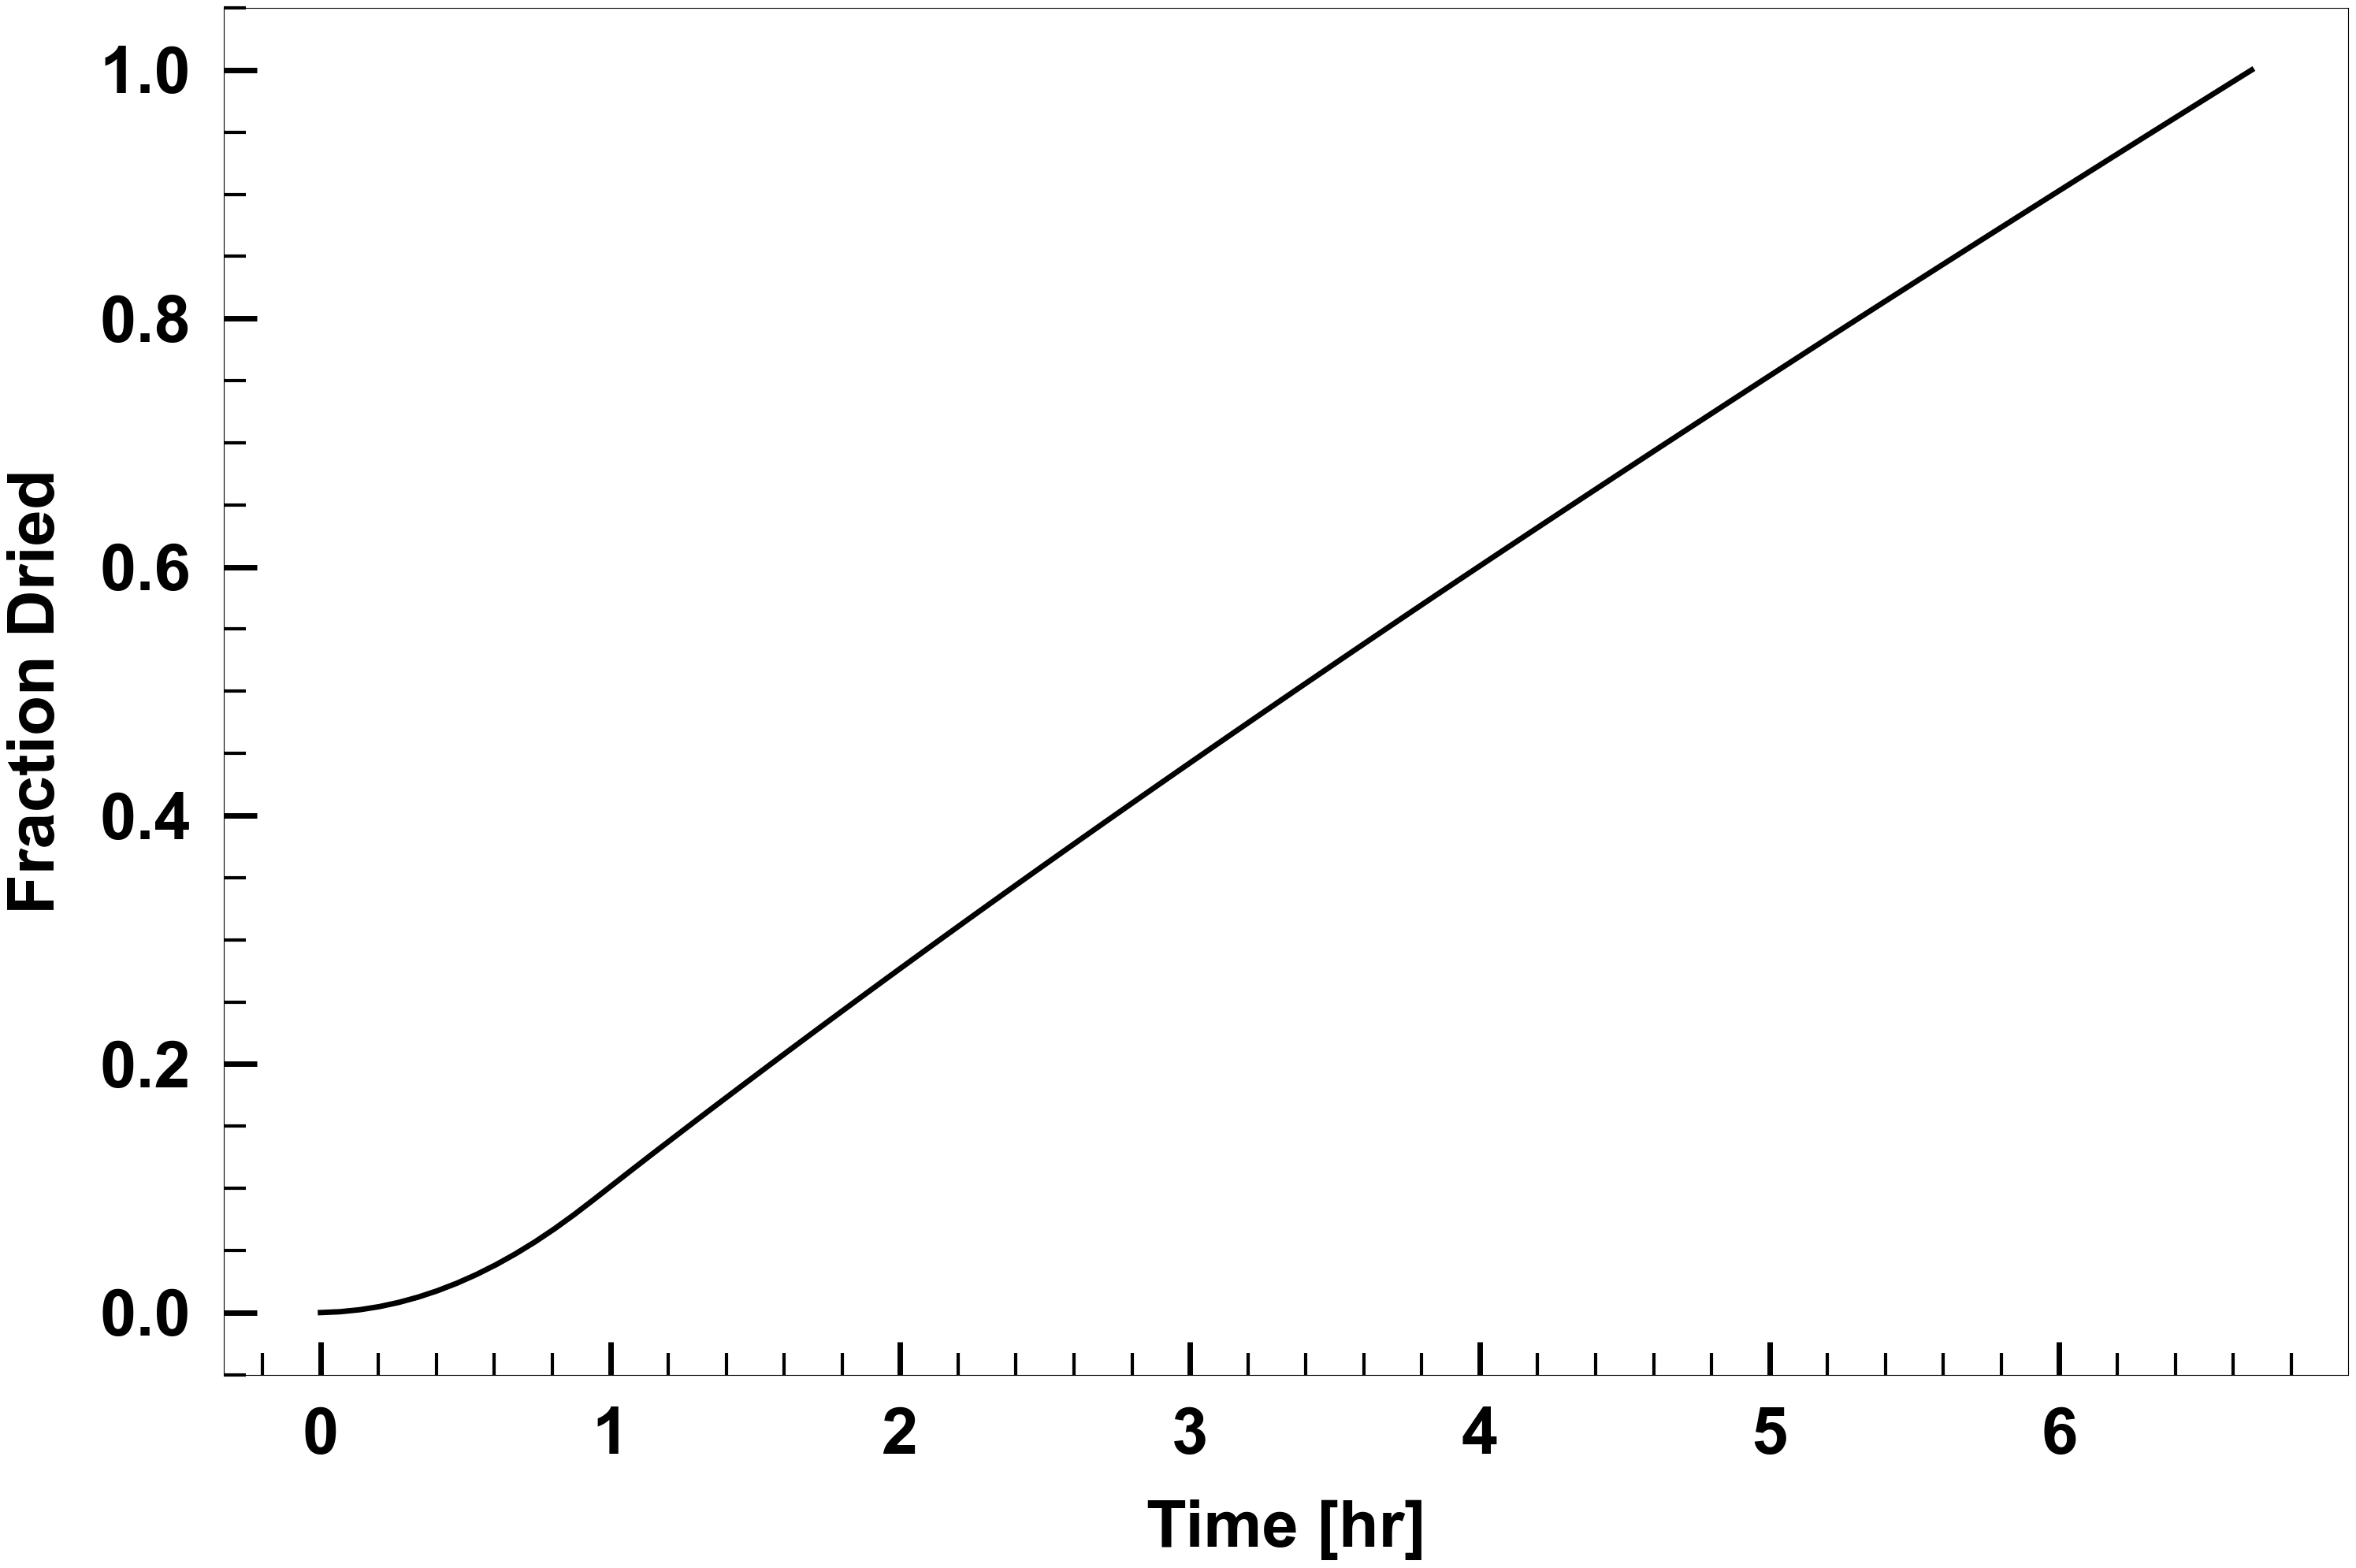

In [10]:

fig = plt.figure(0,figsize=(figwidth,figheight))
ax = fig.add_subplot(1,1,1)
lp.plot_styling.axis_style_percdried(ax)
ax.plot(output_table[:,0],output_table[:,-1],'-k',linewidth=lineWidth, label = "Percent Dried")
plt.tight_layout()
# figure_name = 'lyopronto_percentdried_'+current_time+'.pdf'
# plt.savefig(figure_name)
# plt.close()


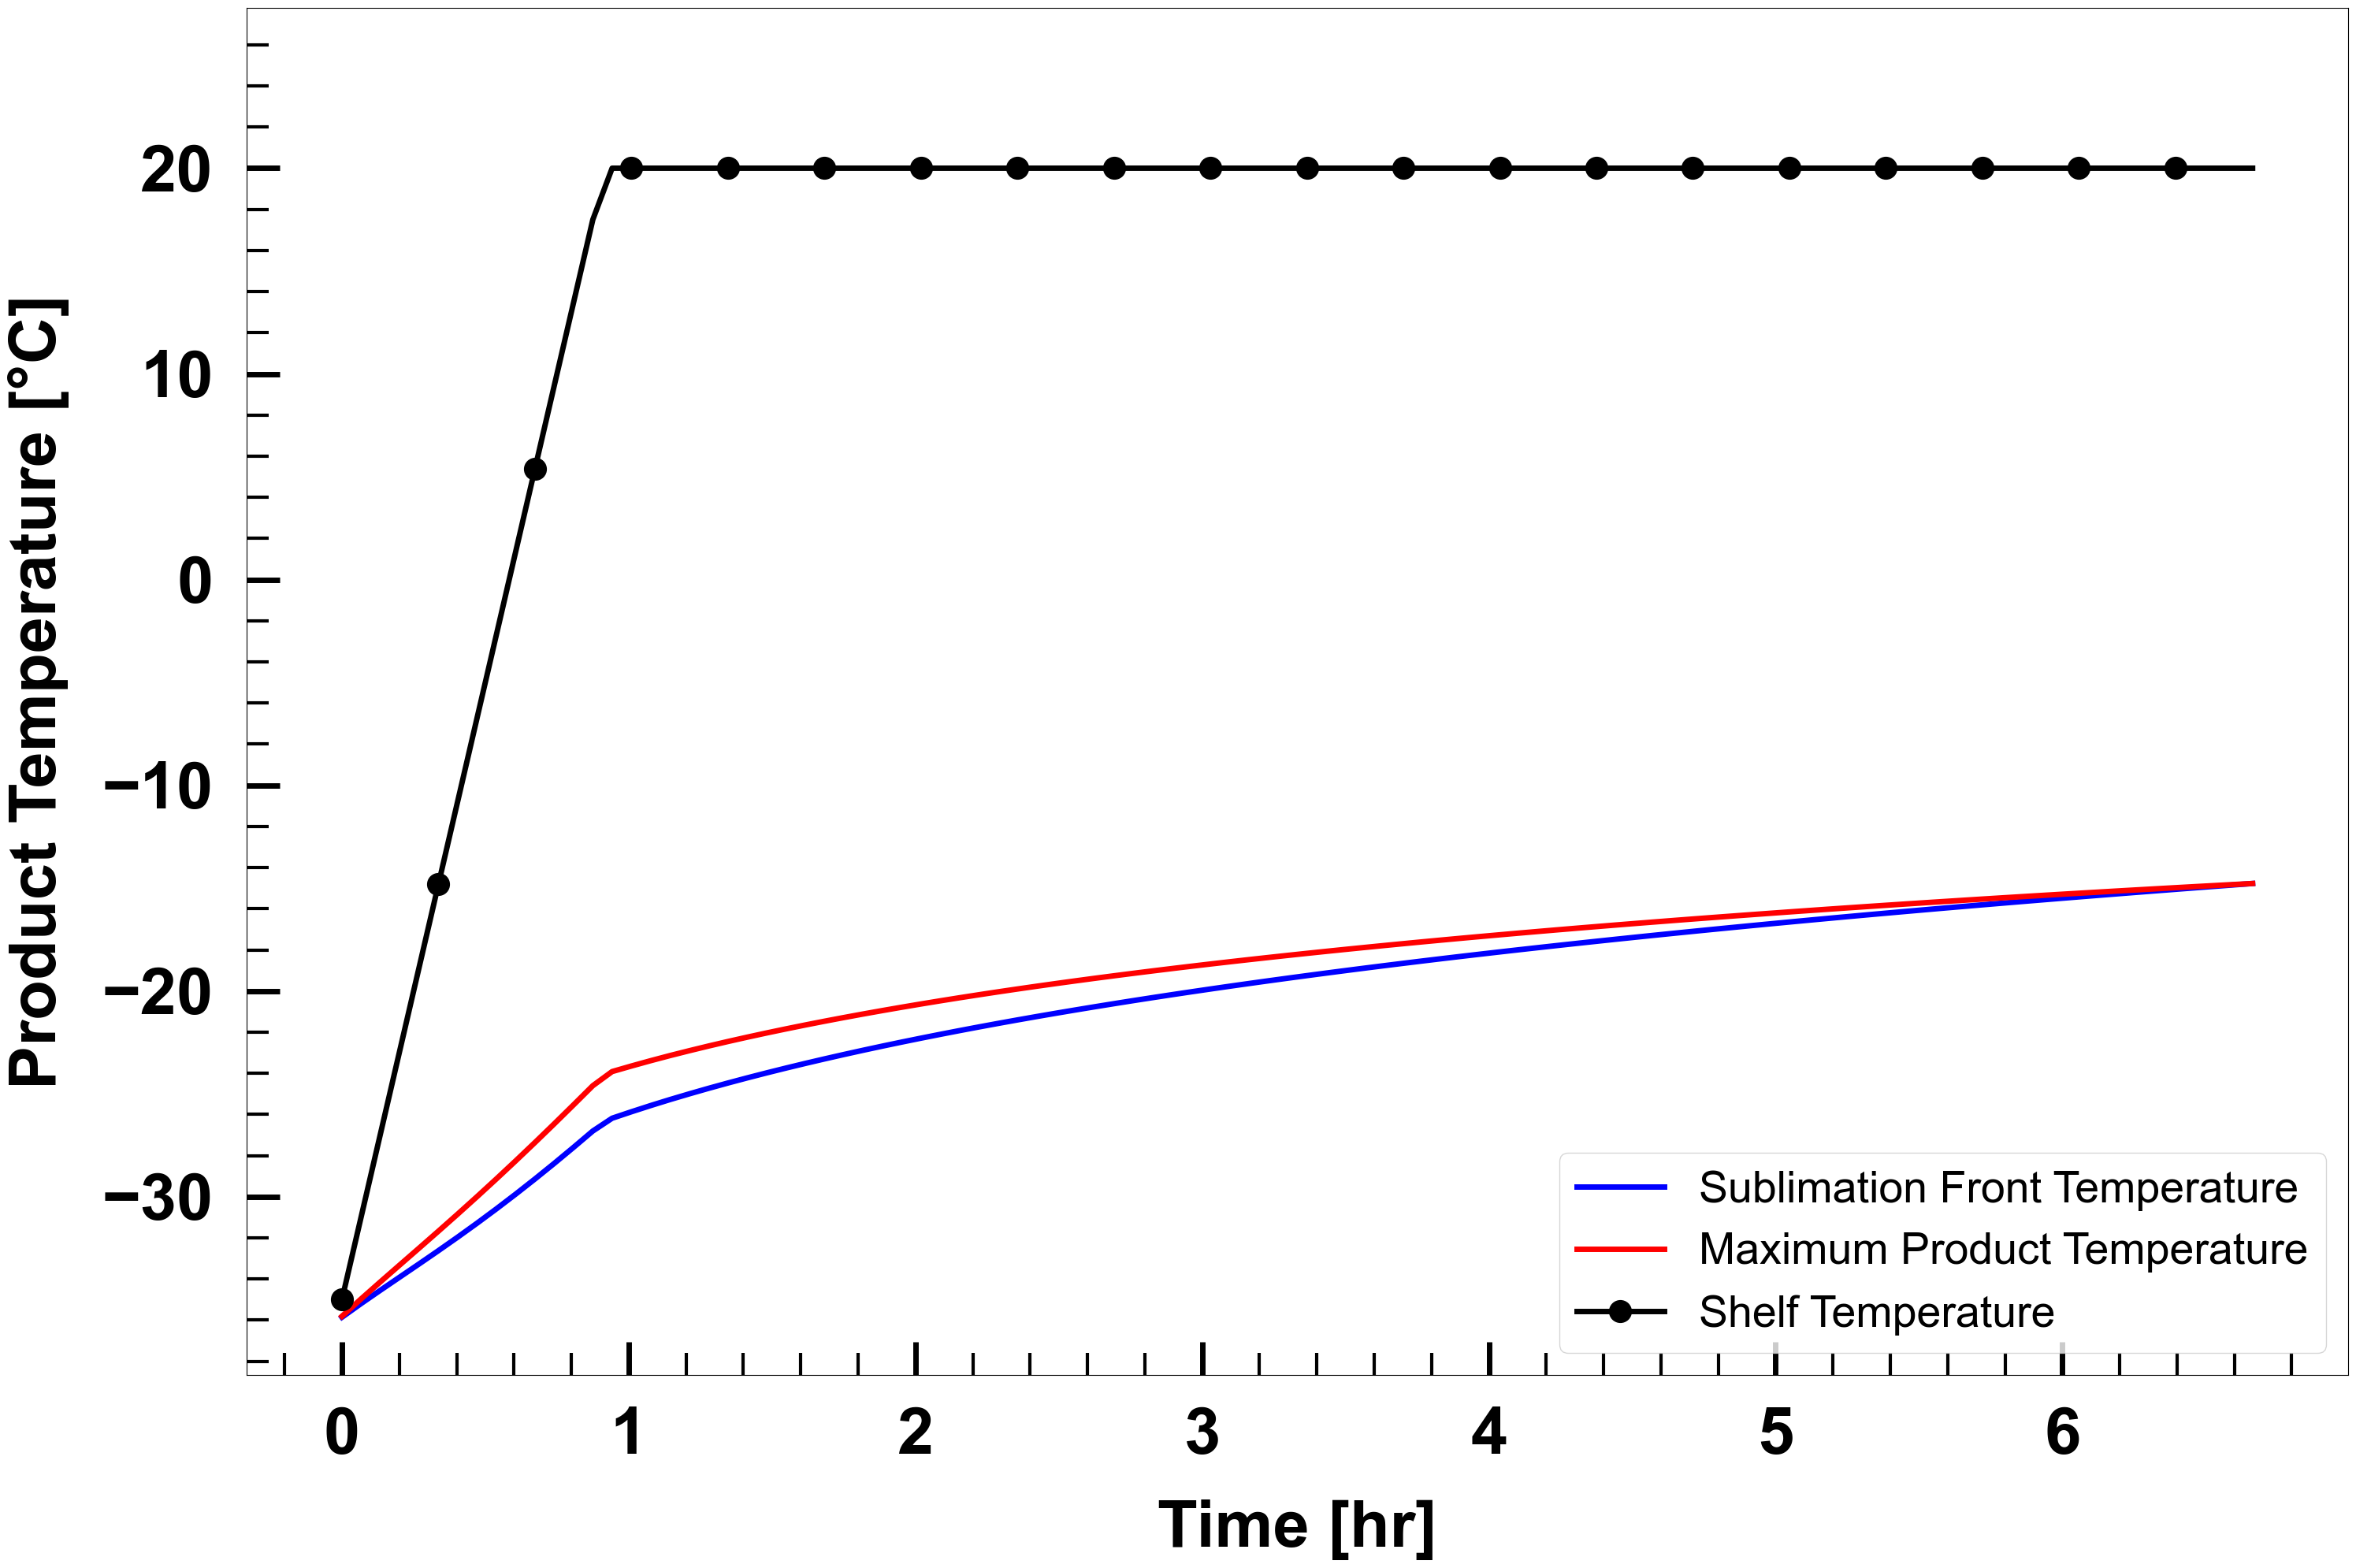

In [11]:

fig = plt.figure(0,figsize=(figwidth,figheight))
ax = fig.add_subplot(1,1,1)
lp.plot_styling.axis_style_temperature(ax)
ax.plot(output_table[:,0],output_table[:,1],'-b',linewidth=lineWidth, label = "Sublimation Front Temperature")
ax.plot(output_table[:,0],output_table[:,2],'-r',linewidth=lineWidth, label = "Maximum Product Temperature")
ax.plot(output_table[:,0],output_table[:,3],'-o',color='k',markevery=5,linewidth=lineWidth, markersize=markerSize, label = "Shelf Temperature")
plt.legend(fontsize=40,loc='best')
ll,ul = ax.get_ylim()
ax.set_ylim([ll,ul+5.0])
plt.tight_layout()
# figure_name = 'lyopronto_temperatures_'+current_time+'.pdf'
# plt.savefig(figure_name)
# plt.close()
